In [38]:
from langchain_ollama import ChatOllama
from langchain_groq import ChatGroq

# llm = ChatOllama(model='llama3.2')
llm = ChatGroq(model="llama-3.1-70b-versatile")

In [39]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from langgraph.graph import add_messages
from operator import add

class Joke(TypedDict):
  associations: list[str]
  joke: str

class State(TypedDict):
  messages: Annotated[list[AnyMessage], add_messages] = None
  words: list[str]
  associations: Annotated[list[list[str]], add] = []
  jokes: Annotated[list[Joke], add] = []
  best_jokes: list[int] = []
  

In [40]:
from langgraph.graph import StateGraph, START, END
from langgraph.constants import Send
from typing import Literal
from pydantic import BaseModel

class AssociationState(TypedDict):
  word: str

class AssociationsStateOutput(BaseModel):
  associations: list[str]
  
llm_with_associations_list = llm.with_structured_output(AssociationsStateOutput)

def generate_associations(state: AssociationState):
  sys_msg = f"""
  You are an assistant to help find associations with the word that the user provide..
  List everything you can think about the subjest using the subcategories of People, Places, Things, Words, Phrases, Cliches, Events.
  
  Only output the list of associations
  """
  
  req_msg = f"""List 7 things you can think about {state['word']} """
  
  association_output = llm_with_associations_list.invoke([SystemMessage(sys_msg), HumanMessage(req_msg)])
  
  return {
    'associations': [association_output.associations]
  }



In [41]:

# Edge
def distribute_condition(state) -> Literal["generate_associations"]:

  return [Send("generate_associations", {"word": word}) for word in state['words']]

# State
def pick_two_associations(state):
  sys_msg = f"""You are a joke writer. 
  First, Choose one items from each list.
  Then make a joke associating the two picked items.
  
  list1: {state['associations'][0]}
  list2: {state['associations'][1]}

  """
  req = f"""
  Tell me a funny joke!   
  Let's think step by step
  """
  response = llm.invoke([SystemMessage(sys_msg), HumanMessage(req)])
  return {
    'messages': [response],
    'jokes': [response.content]
  }

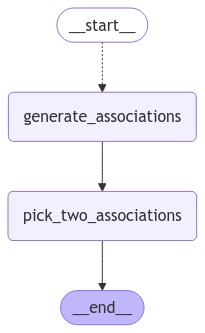

In [42]:
from langgraph.graph import StateGraph, START, END


builder = StateGraph(State)

builder.add_node(generate_associations)
builder.add_node(pick_two_associations)

builder.add_conditional_edges(START, distribute_condition)
builder.add_edge('generate_associations', 'pick_two_associations')
builder.add_edge('pick_two_associations', END)

graph = builder.compile()

from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [43]:
state = {
  'words': ['pill', 'phone']
}

response = graph.invoke(state)

NotImplementedError: Unsupported message type: <class 'list'>
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/MESSAGE_COERCION_FAILURE

In [18]:
response

NameError: name 'response' is not defined